**<h1>Import all Neccesary Libraires and Modules</h1>**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA

# Suppress specific FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

**<h1>Exploratory Data Analysis & Data Cleaning</h1>**

Index(['Genre'], dtype='object')

Tempo                          0
Dynamics Range                 0
Vocal Presence                 0
Percussion Strength            0
String Instrument Detection    0
Electronic Element Presence    0
Rhythm Complexity              0
Drums Influence                0
Distorted Guitar               0
Metal Frequencies              0
Ambient Sound Influence        0
Instrumental Overlaps          0
Genre                          0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tempo                        890 non-null    float64
 1   Dynamics Range               890 non-null    float64
 2   Vocal Presence               890 non-null    float64
 3   Percussion Strength          890 non-null    float64
 4   String Instrument Detection  890 non-null    float64
 5   Electro

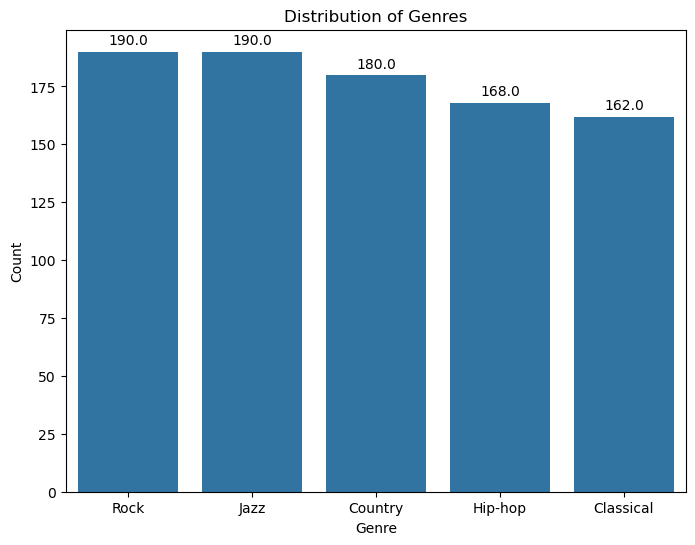

In [2]:
# import dataset
task_dataset = pd.read_csv('music_dataset_mod.csv')
#print(task_dataset.head(20), end='\n\n')

# check for null values
print(task_dataset.columns[task_dataset.isnull().any()], end='\n\n')

# clean task_dataset
music_features = task_dataset.copy()
music_features.dropna(inplace=True)
music_features = music_features.reset_index(drop=True)

print(music_features.isna().sum(), end='\n\n') #verify they are all gone

# investigate dataset and target columns
print(music_features.info(), end='\n\n')
print(music_features['Genre'].value_counts(), end='\n\n')

# visulaize distribution of Genres unique values
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Genre', data=music_features, order=music_features['Genre'].value_counts().index)
plt.title('Distribution of Genres')
plt.ylabel('Genre')
plt.ylabel('Count')

# Annotate the bars with the count values
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
    
plt.show()

**<h1>Correlation Analysis</h1>**

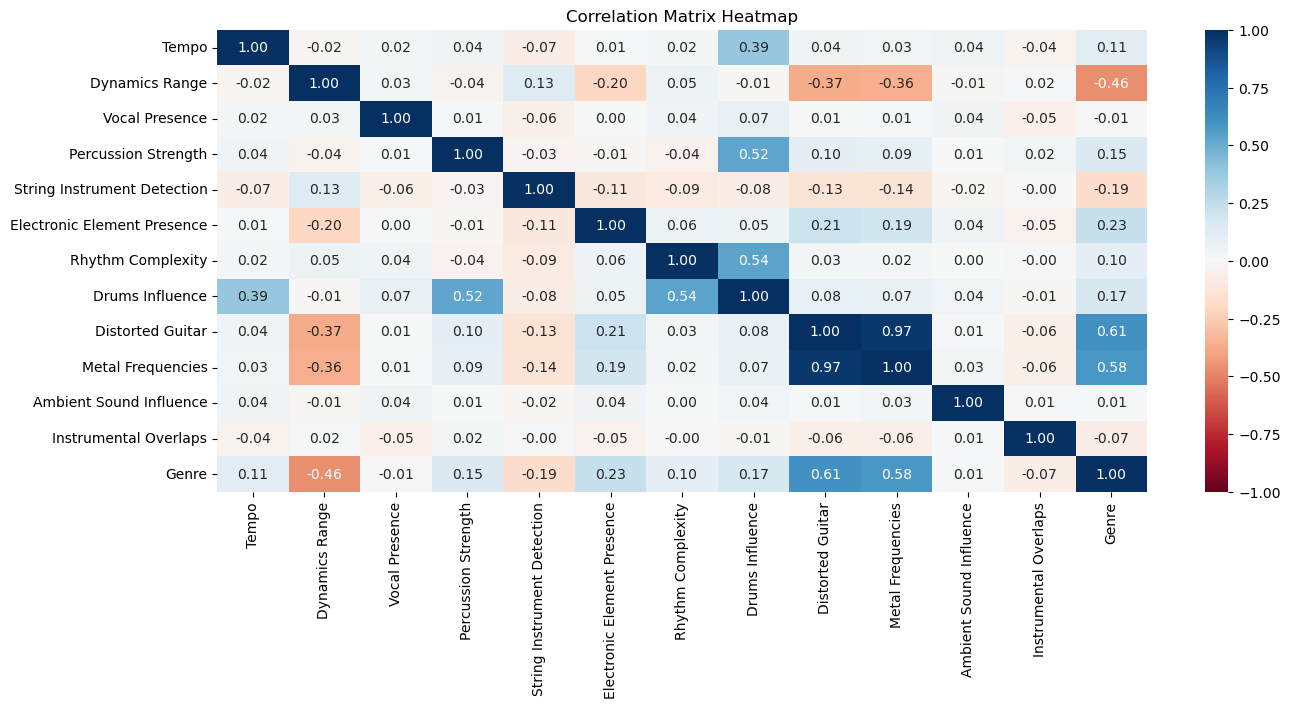

In [3]:
# transformed our only categorical (norminal) variables into numerical ones
le = LabelEncoder()
music_features['Genre'] = le.fit_transform(music_features['Genre'])

# correlation analysis
corr_matrix = music_features.corr()

# visulaise with heatmap
plt.figure(figsize=(15,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='RdBu', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

**<h1>Principal Component Analysis (PCA) for Dimensionality Reduction</h1>**

[0.20063071 0.15062807 0.09369199 0.08696907 0.08536054 0.08167379
 0.07948271 0.07613474 0.07000221 0.05996203 0.01267309 0.00279105]


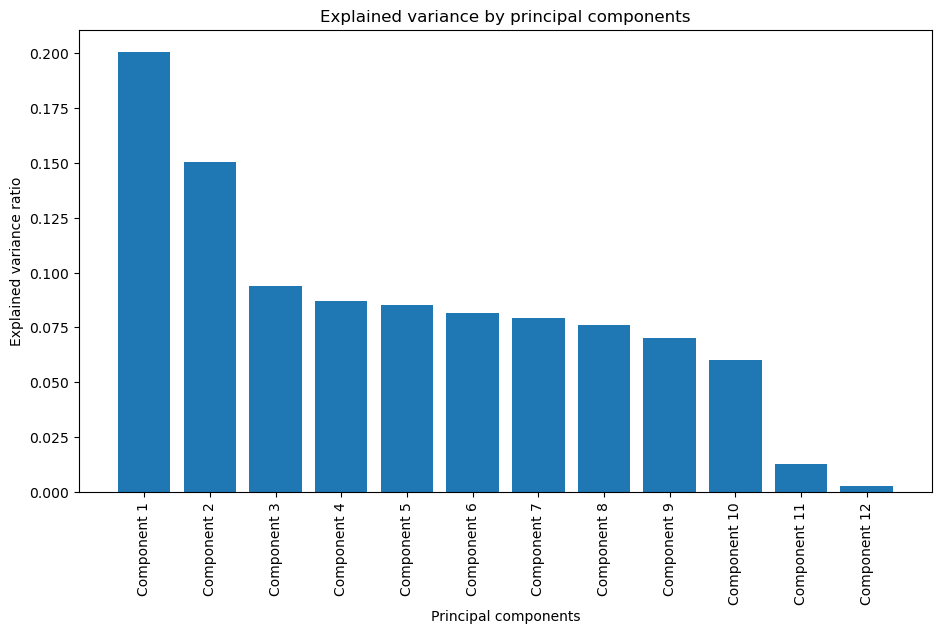

In [4]:
# split input and output data
X = music_features.drop('Genre',axis =1)
y = music_features.iloc[:,-1]

# standardize input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# apply PCA
pca = PCA()
pca.fit_transform(X)
print(pca.explained_variance_ratio_)

# visulaizing pca.explained_variance_ratio_
plt.figure(figsize=(11,6))
components = [f'Component {i}' for i in range(1, 13)]
var_exp = pca.explained_variance_ratio_
plt.bar(components, var_exp)
plt.xticks(rotation=90)
plt.title('Explained variance by principal components')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.show()

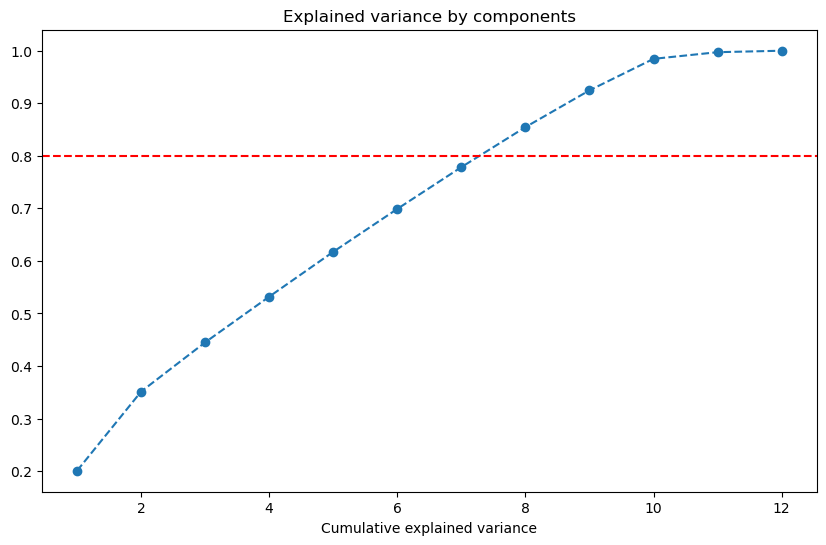

Number of components to retain: 8


In [5]:
# cummulative variance to determine the no of components
plt.figure(figsize=(10,6))
plt.plot(range(1,13), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.8, color='red', linestyle='--')
plt.title('Explained variance by components')
plt.xlabel('Cumulative explained variance')
plt.show()


# OR
num_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.8) + 1
print(f'Number of components to retain: {num_components}')

In [6]:
# reapply PCA
pca_final = PCA(n_components=8)
X = pca_final.fit_transform(X)

**<h1>Model Development and Evaluation</h1>**

              precision    recall  f1-score   support

   Classical       0.89      0.98      0.93        51
     Country       0.32      0.23      0.27        52
     Hip-hop       0.49      0.44      0.46        48
        Jazz       0.41      0.42      0.42        62
        Rock       0.51      0.63      0.56        54

    accuracy                           0.54       267
   macro avg       0.52      0.54      0.53       267
weighted avg       0.52      0.54      0.52       267



Text(0.5, 1.0, 'LG Confusion Matrix')

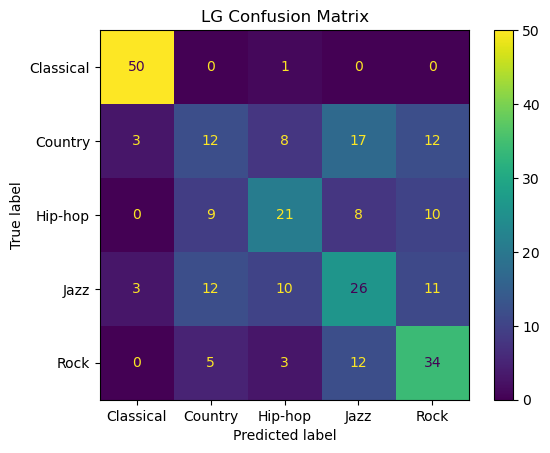

In [13]:
# splittig the dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LG classification model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# change labels to original form
y_pred_orig = le.inverse_transform(y_pred)
y_test_orig = le.inverse_transform(y_test)

# performance report
cf_report = classification_report(y_test_orig, y_pred_orig, digits=2)
print(cf_report)

# confusion matrix
cf_matrix = confusion_matrix(y_test_orig, y_pred_orig)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=le.classes_)
disp.plot()
plt.title('LG Confusion Matrix')

**<h1>Prediction and Filling Missing Values</h1>**

In [16]:
# prepare input features
genre_unknown = task_dataset[task_dataset['Genre'].isna()]
genre_unknown = genre_unknown.drop('Genre', axis=1)
genre_unknown.reset_index(drop=True, inplace=True)

genre_unknown = scaler.fit_transform(genre_unknown)  # standardize
genre_unknown = pca_final.fit_transform(genre_unknown) # reduce dimensions

# generate predicted genres
genre_fill = classifier.predict(genre_unknown)
predicted_genres = le.inverse_transform(genre_fill)

# update the original dataset with the predicted genres
task_dataset_nonull = task_dataset.copy()
task_dataset_nonull.loc[task_dataset_nonull['Genre'].isna(), 'Genre'] = predicted_genres

# save the dataset with filled columns into a new csv file
task_dataset_nonull.to_csv('music_dataset_nonull.csv', index=False)